In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import math

In [2]:
# Importing the data from the four runs
mdata1 = np.loadtxt('22-11-15-03-40.data') 
mdata2 = np.loadtxt('22-11-22-01-18.data') 
mdata3 = np.loadtxt('22-11-22-08-30.data') 
mdata4 = np.loadtxt('22-11-23-03-48.data')

# taking first element of each list in a lists of imported data
list1 = [element[0] for element in mdata1]  
list2 = [element[0] for element in mdata2] 
list3 = [element[0] for element in mdata3] 
list4 = [element[0] for element in mdata4] 

list_total = list1 + list2 + list3 + list4  # adding up data from different runs together

decaytimes = [i/1000 for i in list_total if i<=20000] # taking only values smaller than 20000 and changing units to microseconds

In [3]:
# number of bins is chosen as rounding up of square root of number of data points
binnumber = math.ceil(np.sqrt(len(decaytimes)))

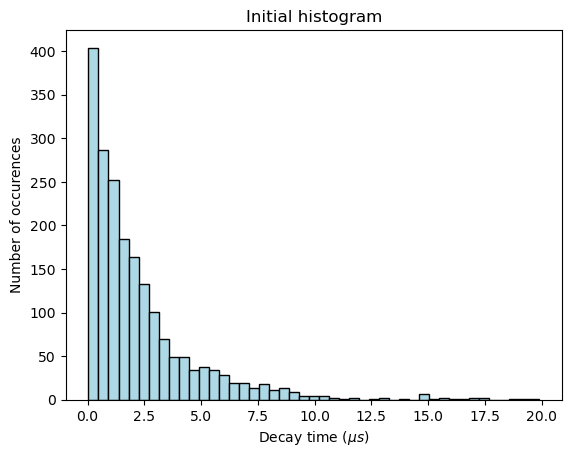

In [4]:
# plotting initial histogram to see the data
plt.figure()

plt.hist(decaytimes,bins=binnumber,edgecolor='k', color='lightblue') 
plt.title("Initial histogram")
plt.xlabel(r'Decay time $(\mu s)$')
plt.ylabel("Number of occurences");
plt.savefig('initial_histogram.png')

Now, we need to define a function, according to our theoretical model, for fitting. This function is a general exponential:

$$f(t) = A exp(-\frac{1}{\tau} t) + B$$

Where: A and B are fit constants, $\tau$ is also a fit constant, which interests us the most, it is the muon lifetime. 
In this model, B accounts for noise. 

In [5]:
# defining function for fitting
def fit_function(x,Tau,A,B):
    return ( A* np.exp(-x/Tau) + B)

# Initial fitting

A simple fit to data is performed, using the function defined above.  

In [6]:
counts_0, bins_0 = np.histogram(decaytimes, bins=binnumber, range = (0,20))   # taking data as sorted into bins by histogram
# this outputs list of numbers of counts of data in each bin (counts_0) and list of limits of bins. 

binscenters_0 = np.array([0.5 * (bins_0[i] + bins_0[i+1]) for i in range(len(bins_0)-1)])   # calculating bin's centers

binwidth_0 = 20/binnumber  # calculate width of each bin as total range divided by number of bins in this range

In [7]:
# performing initial fit
popt_0, pcov_0 = curve_fit(fit_function, xdata=binscenters_0, ydata=counts_0, p0=[2,100,0])
print(popt_0)

[  2.03463061 417.41626099   1.39997235]


Next, we can plot histogram together with fitted function:

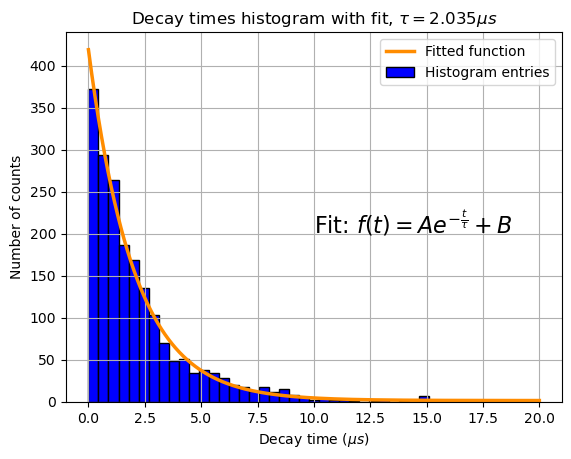

<Figure size 640x480 with 0 Axes>

In [8]:
x_axis = np.linspace(0, 20, 10000)  # x axis for plotting function

# Plotting histogram with fitted function
plt.figure()

plt.bar(binscenters_0, counts_0, width=binwidth_0, color='blue', label=r'Histogram entries',edgecolor='k') # histogram
plt.plot(x_axis, fit_function(x_axis, *popt_0), color='darkorange', linewidth=2.5, label=r'Fitted function') # fit function


plt.xlabel(r'Decay time $(\mu s)$')
plt.ylabel(r'Number of counts')
plt.title(r'Decay times histogram with fit, $ \tau = 2.035 \mu s $')
plt.legend(loc='best')
plt.grid()
plt.text(10, 200, r'Fit: $ f(t) = A e^{-\frac{t}{\tau}} + B $ ', fontsize = 16)
plt.show()
plt.savefig('initial_histogram_with_fit.png')

# Improved fitting

Next, we need to take into account the vertical uncertainties of each bin and we also want to cut out all the data below certain decay time. We determined this cut value to be 2.52 microseconds.

In [9]:
# It is useful to define function for cutting out databelow given threshold:
def cut_data(data_list, cut_value):
    """
    Takes data in a form of a list of values, eliminates all the elements below given value (cut_value) from the list.
    Inputs: list containing data which we want to cut, cut threshold value
    
    Output: list of new data containing only values above the cut threshold
    
    """
    decaytimes_new = [i for i in data_list if i>=cut_value]
    
    return decaytimes_new

Since we want to use Poisson uncertainties for counts in bins, we need to ensure that each bin contains at least 5 counts, to do that, we add up together bins untill all the bins have at least 5 counts. A function is defined to do that:

In [10]:
# defining function which groups together bins, this function goes in order from last to first bin
def connect_bins(counts_list):
    
    """
    Connects bordering bins together in such a way that all bins have at least 5 counts. Starts with leftmost bins and goes 
    to the right. 
    
    Input: original list of counts in bins
    
    Output: new list of counts in bins, such that all bins have at least 5 counts
    """
    
    N = len(counts_list)
    n = N - 1
    value1 = 5  # minimum bin count
    
    # empty lists
    bins_comb = []
    new_counts = []

    while n >= 0:
    
        
        new_element = counts_list[n] # New bin is initially taken as n th bin
        
        k = 1
        # While our new bin height is smaller than value1, keep adding to it next bins
        while new_element < value1:  
            new_element = new_element + counts_list[n - k]
            k = k+1
            
        bins_comb.append(k)  # this list will tell us how many bins we added together for given new bin
    
        new_counts.append(new_element) # this list contains new bins
        
    
        n = n-k  # we grouped together k bins, now we jump by k to the next, ungrouped bin (in last to first bin order)
    
    
    # both of these lists are in reversed order
    new_counts.reverse()   
    bins_comb.reverse()
    
    return new_counts, bins_comb

In [11]:
cut_1 = 2.52 # our cut threshold
decaytimes_cut = cut_data(decaytimes, cut_1) # cutting original data

# number of bins is chosen as rounding up of square root of number of data points
binnumber_cut = math.ceil(np.sqrt(len(decaytimes_cut)))

In [12]:
# taking cut data as sorted into bins by histogram, then calculate positions of centers of the bins
counts_cut, bins_cut = np.histogram(decaytimes_cut, bins=binnumber_cut, range = (cut_1,20))  
binscenters_cut = np.array([0.5 * (bins_cut[i] + bins_cut[i+1]) for i in range(len(bins_cut)-1)])

In [13]:
# we use connect_bins() function to group together bins, as mentioned before
new_counts_cut = connect_bins(counts_cut)[0]  # list of new counts
new_bins_cut = connect_bins(counts_cut)[1]  # list of how many bins were grouped for given new bin

The new_bins_cut list is useful for calculation positions of centers of new bins, which we need for the fit. This list tells us how many bins were grouped together for given bin, it is of the form for example: [1,1,1,3,4], thich we can understand as: first three bins remained unchanged, for next two bins, respectively 3 and 4 bins vere grouped together to obtain at least 5 counts in each. 

In [14]:
# calculating width of new bins
new_binwidths_cut = np.array(new_bins_cut)*(20-cut_1)/binnumber_cut

In [15]:
# calculating new bins centres positions
i = 0
new_binscenters_cut = []

# Calculate new bins centers positions by taking half width of current bin and adding upp all the previous bin widths
while i < len(new_binwidths_cut):
    new_binscenters_cut.append(0.5*new_binwidths_cut[i] + sum(new_binwidths_cut[0:i]) +cut_1 )
    i = i+1

In [16]:
# performing fit: x data is positions of bins centres, y data is counts in bins
# errors in vertical data are taken as square roots of counts in respective bins

popt,pcov = curve_fit(fit_function, xdata=new_binscenters_cut, ydata=new_counts_cut, p0=[2,100,0],sigma=np.sqrt(new_counts_cut))

In [17]:
# printing out fit parameters, and uncertainty of first parameter which is lifetime
# uncertainty is a square root of adequate element of covariance matrix pcov
print(popt)
print(np.sqrt(pcov[0,0]))

[  2.13770875 543.97203283   4.87917751]
0.157535776845705


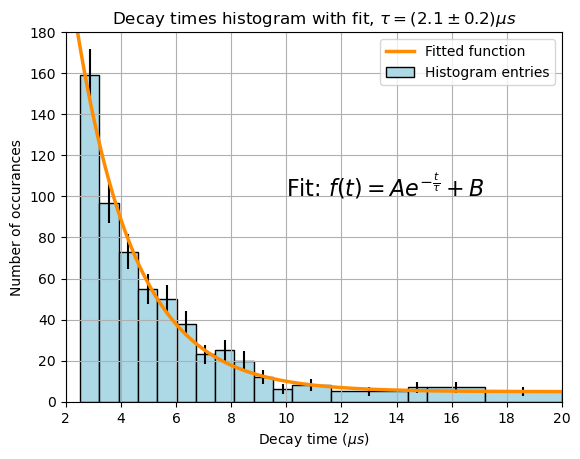

<Figure size 640x480 with 0 Axes>

In [18]:
x_axis = np.linspace(0, 20, 10000)  # x axis for plotting function

# Plotting histogram with fitted function
plt.figure()

plt.bar(new_binscenters_cut,new_counts_cut,width=new_binwidths_cut,color='lightblue',label=r'Histogram entries',edgecolor='k',yerr=np.sqrt(new_counts_cut)) # histogram
plt.plot(x_axis, fit_function(x_axis, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function') # fit function


plt.xlabel(r'Decay time $(\mu s)$')
plt.ylabel(r'Number of occurances')
plt.title(r'Decay times histogram with fit, $ \tau = (2.1  \pm 0.2) \mu s$')

plt.xlim(2,20)
plt.ylim(0,180)
plt.legend(loc='best')
plt.grid()
plt.text(10, 100, r'Fit: $ f(t) = A e^{-\frac{t}{\tau}} + B $ ', fontsize = 16)
plt.show()
plt.savefig('final_histogram.png')

# Investigating the fit parameters

Next, we can investigate our fit, how it depends on different parameters. Here, dependnce on initial number of bins (before combining them together) and on the cut threshold is investigated. It is useful to define function that does the entire fit, since we want to investigate number of bins, this function also takes this as an input. 

In [19]:
# defining function
def fit_newbins_cut(decaytimes_list, cut_value, number_of_bins):
    """
    Cuts data below cut_value threshold, sorts data into histogram counts with bin number number_of_bins, connects bins together
    such that all bins have at least 5 counts. Performs fit to the data. 
    
    Iputs: 
    - list containing data (decaytimes_list)
    - cut threshold (cut_value)
    - number of bins for the initial histogram (number_of_bins)
    
    Outputs:
    - list of fit parameters (popt)
    - covariance matrix (pcov)
    - list of positions of final bins (new_binscenters_cut_1)
    - list of counts in bins (new_counts_cut_1)
    - list of bin widths (new_binwidths_cut_1)
    """
    
    
    # cutting the data
    decaytimes_cut_1 = cut_data(decaytimes, cut_value)

    # taking data as sorted into bins by histogram
    counts_cut_1, bins_1 = np.histogram(decaytimes_cut_1, bins=number_of_bins, range = (cut_value,20))  
    binscenters_cut_1 = np.array([0.5 * (bins_1[i] + bins_1[i+1]) for i in range(len(bins_1)-1)])   # calculating bin's centers

    # connecting the bins
    new_counts_cut_1 = connect_bins(counts_cut_1)[0]
    new_bins_cut_1 = connect_bins(counts_cut_1)[1]

    new_binwidths_cut_1 = np.array(new_bins_cut_1)*(20-cut_value)/number_of_bins   # new bins widths


    i = 0
    new_binscenters_cut_1 = []

    # Calculate new bins centers positions by taking half width of current bin and adding upp all the previous bin widths
    while i < len(new_binwidths_cut_1):
        new_binscenters_cut_1.append(0.5*new_binwidths_cut_1[i] + sum(new_binwidths_cut_1[0:i]) +cut_value )
        i = i+1
    
    # performing fit
    sigma1 = np.sqrt(new_counts_cut_1) # y error
    popt,pcov= curve_fit(fit_function, xdata=new_binscenters_cut_1, ydata=new_counts_cut_1, p0=[2,100,0],sigma=sigma1)  # fit
    
    
    return popt, pcov, new_binscenters_cut_1, new_counts_cut_1, new_binwidths_cut_1

Next, the function is tested for the same parameters as previous fit:

In [20]:
cut = 2.52
binnumber = math.ceil(np.sqrt(len(cut_data(decaytimes, cut))))

fit_newbins_cut(decaytimes, cut, binnumber )[0]

array([  2.13770875, 543.97203283,   4.87917751])

Parameters are exactly the same as previously, as expected. Now, using this function we can vary its inputs and observe changes to the fit parameters, we start by fitting across a range of different cut thresholds:

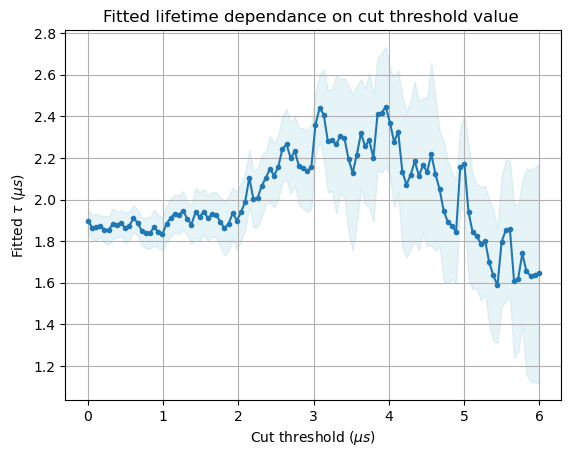

In [21]:
fit_values = [] # empty list that will contain fitted parameters tau
fit_uncertainties = [] # empty list that will contain uncertainties of the fitted parameter tau
cut = 0 # initial cut value

# loop for fitting until certain cut value is reached
while cut <= 6.00001:
    
    
    
    binnumber_cut = math.ceil(np.sqrt(len(cut_data(decaytimes, cut)))) # calculate number of bins
    
    fit_values.append(fit_newbins_cut(decaytimes, cut, binnumber_cut)[0][0]) # fit using previously defined function
    
    fit_uncertainties.append(np.sqrt(fit_newbins_cut(decaytimes, cut, binnumber_cut)[1][0][0]))
    
    
    cut= cut+ 0.055 # cut increment

# plot fit parameters vs cut value
plt.figure()
plt.plot(np.arange(0,6.01,0.055),fit_values,'.-')

plt.fill_between(
    np.arange(0, 6.01, 0.055),
    np.array(fit_values) - np.array(fit_uncertainties),
    np.array(fit_values) + np.array(fit_uncertainties),
    color='lightblue',
    alpha=0.3
)

plt.grid()
plt.xlabel(r'Cut threshold $(\mu s)$')
plt.ylabel(r'Fitted $\tau$ $(\mu s)$')
plt.title(r'Fitted lifetime dependance on cut threshold value ')

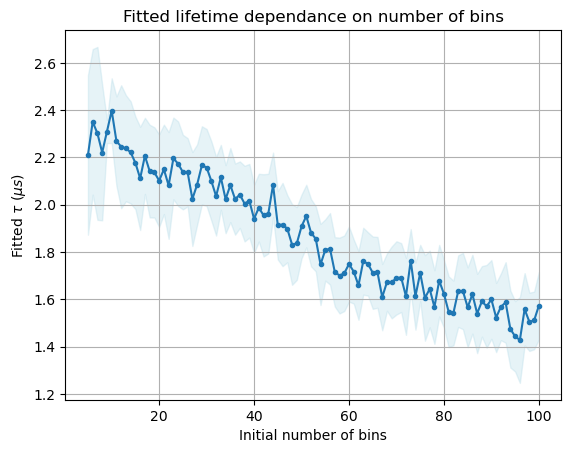

In [22]:
fit_values_2 = [] # empty list that will contain fitted lifetimes
fit_uncertainties2 = [] # empty list that will contain uncertainties of the fitted parameter tau
bin_number = 5  # initial bin number

# perform fitting in a loop until number of bins reaches 100
while bin_number <= 100:
    
    
    
    fit_values_2.append(fit_newbins_cut(decaytimes, 2.52, bin_number)[0][0]) # add fitted lifetime to the list
    
    fit_uncertainties2.append(np.sqrt(fit_newbins_cut(decaytimes, 2.52, bin_number)[1][0][0]))
    
    bin_number= bin_number + 1 # increment in number of bins
    
    
    
# plotting results, fitted lifetime vs initial number of bins
plt.figure()
plt.plot(np.arange(5,100.1,1),fit_values_2,'.-')

plt.fill_between(
    np.arange(5,100.1,1),
    np.array(fit_values_2) - np.array(fit_uncertainties2),
    np.array(fit_values_2) + np.array(fit_uncertainties2),
    color='lightblue',
    alpha=0.3
)

plt.grid()
plt.xlabel(r'Initial number of bins')
plt.ylabel(r'Fitted $\tau$ $(\mu s)$')
plt.title(r'Fitted lifetime dependance on number of bins')

We can look at two example plots for different bin number: 

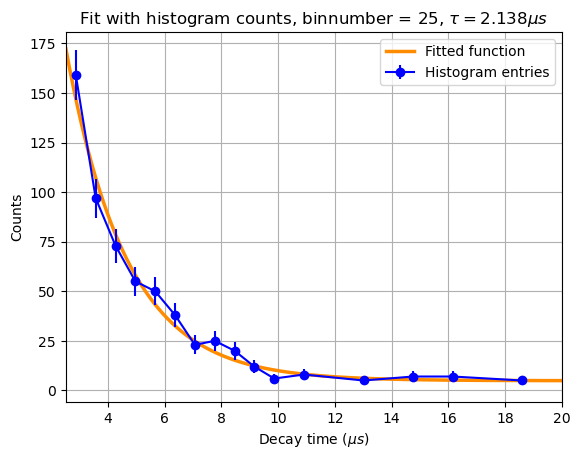

[  2.13770875 543.97203283   4.87917751]


<Figure size 640x480 with 0 Axes>

In [23]:
cut = 2.52 # cut value

fit_par, fit_pcov, b_cent, b_height, b_width = fit_newbins_cut(decaytimes, cut, 25) # fit, bin number = 25

x_axis = np.linspace(cut, 20, 10000)  # x axis for plotting fit function

# plot the results
plt.figure()

plt.plot(x_axis, fit_function(x_axis, *fit_par), color='darkorange', linewidth=2.5, label=r'Fitted function') # plot fit

plt.errorbar(b_cent, b_height,yerr=np.sqrt(b_height), fmt = '-o' ,color='blue', label=r'Histogram entries' ) # plot data


plt.xlim(cut,20)
plt.xlabel(r'Decay time $(\mu s)$')
plt.ylabel(r'Counts')
plt.title(r'Fit with histogram counts, binnumber = 25, $ \tau=2.138 \mu s $')
plt.legend(loc='best')
plt.grid()

plt.show()
print(fit_par)

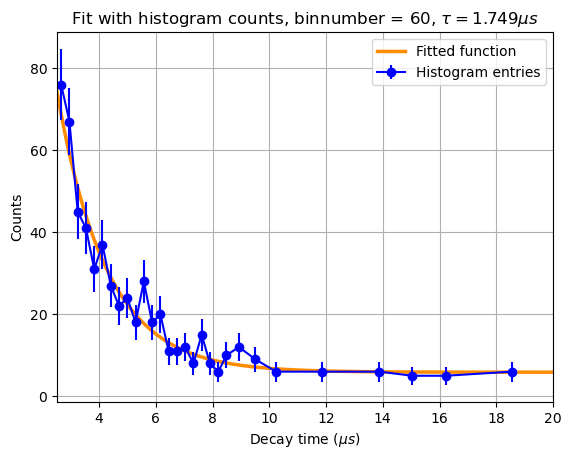

[  1.74884307 288.68215641   5.86189915]


<Figure size 640x480 with 0 Axes>

In [24]:
cut = 2.52 # cut value

fit_par, fit_pcov, b_cent, b_height, b_width = fit_newbins_cut(decaytimes, cut, 60) # fit, bin number = 60

x_axis = np.linspace(cut, 20, 10000)  # x axis for plotting fit function

# plot the results
plt.figure()

plt.plot(x_axis, fit_function(x_axis, *fit_par), color='darkorange', linewidth=2.5, label=r'Fitted function') # plot fit

plt.errorbar(b_cent, b_height,yerr=np.sqrt(b_height), fmt = '-o' ,color='blue', label=r'Histogram entries' ) # plot data

plt.xlim(cut,20)
plt.xlabel(r'Decay time $(\mu s)$')
plt.ylabel(r'Counts')
plt.title(r'Fit with histogram counts, binnumber = 60, $ \tau=1.749 \mu s $')
plt.legend(loc='best')
plt.grid()
plt.show()

print(fit_par)

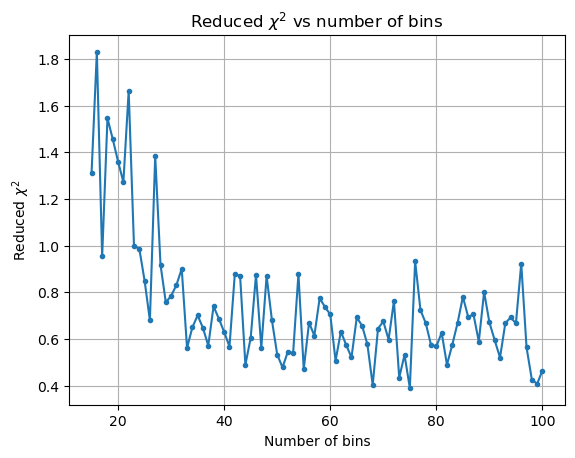

In [25]:
chi_list = [] # empty list which will contain reduced chi squared values
binnumber = 15 # initial number of bins

# while binnumber<=100, perform fit, calculate reduced chi squared and add it to the list
while binnumber <=100:
    
    fit_par, fit_pcov, b_cent, b_height, b_width = fit_newbins_cut(decaytimes, 2.52, binnumber) # fit

    residuals_2 = (np.array(b_height) - fit_function(np.array(b_cent), *fit_par))**2 # residuals squared
    
    chisq = sum(residuals_2/np.array(b_height)) # calculate chi squared
    
    reduced_chisq = chisq/(len(b_cent) - 3) # calculate reduced chi squared
    
    chi_list.append(reduced_chisq) # add to the list

    binnumber = binnumber + 1 # bin number increment

# plotting results
plt.figure()
plt.plot(np.arange(15,100.1,1), chi_list, '.-')
plt.grid()
plt.xlabel(r'Number of bins')
plt.ylabel(r'Reduced $\chi^2$')
plt.title(r'Reduced $\chi^2$ vs number of bins')
plt.savefig('chi_squared_binnumber.png')

For 25 bins, reduced chi squared is 0.850